In [2]:
!pip install nltk
!pip install nltk gensim

# 1. 한글 폰트 설치 (나눔폰트)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 2. Konlpy 설치
!pip install konlpy

# 3. MeCab 설치 (가장 안정적인 방법 하나만 사용)
# 솜장(SOMJANG)님의 Colab용 설치 스크립트 사용
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220429.sh

# 4. tensorflow 토큰화
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.5/803.5 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]1/2 [nltk]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 101.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gensim]2m2/3 [gensim]
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package fonts-nanum is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'fonts-nanum' has no installation candidate
Font directories:
	/root/.local/share/fonts
	/usr/local/share/fonts
	/usr/share/fonts
	/root/.fonts
	/usr/share/texmf/fonts/opentype/public/lm
	/usr/share/texmf/fonts/opentype/public/lm-math
	/usr/share/fonts/X11
	/usr/share/fonts/cMap
	/usr/share/fonts/cmap
	/usr/share/fonts/opentype
	

In [3]:
import numpy
import pandas
import torch
import nltk
import gensim

print(numpy.__version__)
print(pandas.__version__)
print(torch.__version__)
print(nltk.__version__)
print(gensim.__version__)

# 데이터 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 정제
import re

# 한글 나눔고딕 설치
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

# mecab 설치
from konlpy.tag import Mecab

# 1. 라이브러리 import (이 줄이 꼭 필요합니다!)
from tqdm import tqdm

# 데이터 정제 및 분리
import re
from konlpy.tag import Mecab
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 데이터 토큰화_mecab
import os
import pickle
import numpy as np
import tensorflow as tf  # 마스킹 구현을 위해 추가
from collections import Counter
from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.sequence import pad_sequences


2.2.6
2.3.0
2.7.1+cu118
3.9.2
4.4.0


2025-11-26 07:46:34.148033: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-26 07:46:35.968614: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [4]:
FILE_PATH  = "/home/jovyan/work/GitHub/AIFFEL_quest_rs/GoingDeeper/Deeper05/ChatbotData.csv"

df = pd.read_csv(FILE_PATH)
df


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


# 데이터 확인

1) 다른 질문에 대한 동일한 대답
    가족 여행 가기로 했어 - 온 가족이 모두 마음에 드는 곳으로 가세요
    가족 여행 고고 - 온 가족이 모두 마음에 드는 곳으로 가세요
    가족 여행 어디로 가지? - 온 가족이 모두 마음에 드는 곳으로 가세요

2) 동일한 질문에 대한 다른 대답
훔쳐보는 것도 눈치 보임-티가 나니까 눈치가 보이는 거죠!
훔쳐보는 것도 눈치 보임.-훔쳐보는 거 티나나봐요.

3) 어미 다름
가족들이랑 여행갈거야  -좋은 생각이에요
가족이랑 여행가려고 -좋은 생각이에요


[Q]
문장의 최단 길이: 1
문장의 최장 길이: 56
문장의 평균 길이: 12

[A]
문장의 최단 길이: 1
문장의 최장 길이: 76
문장의 평균 길이: 15


/tmp/ipykernel_166/7881370.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(box_data, labels=['Question', 'Answer'], patch_artist=True,


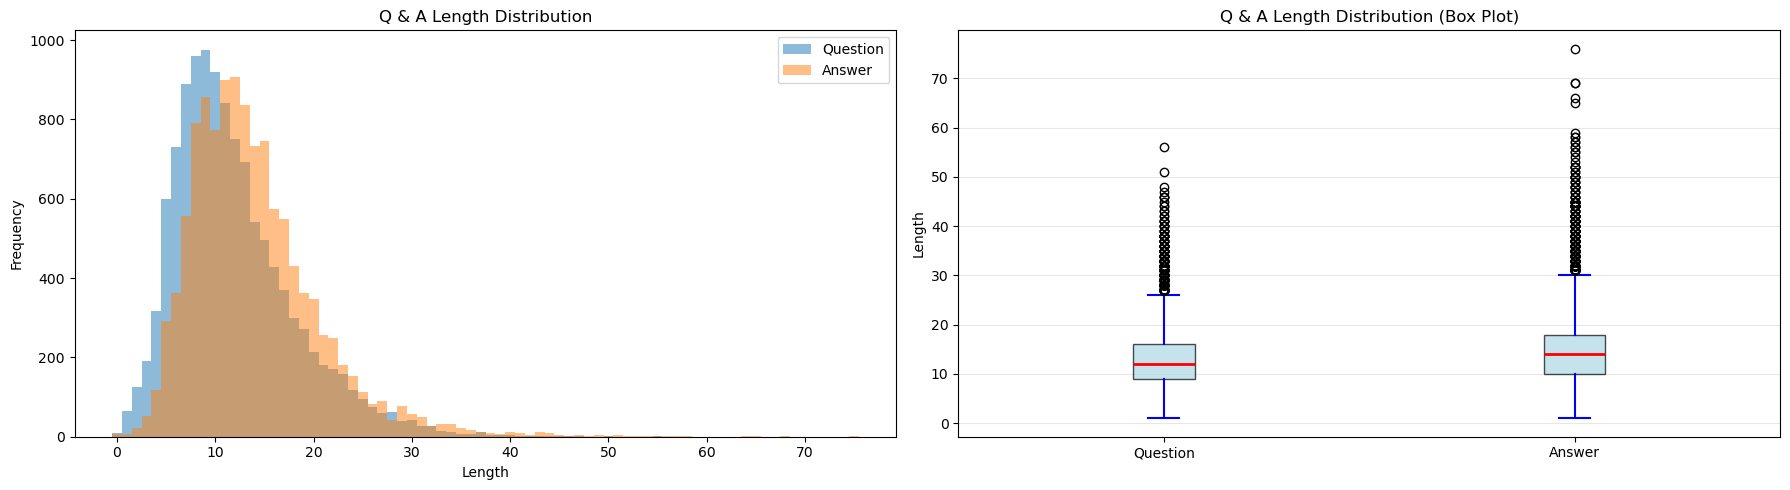


=== IQR 통계 ===

[Question]
Q1 (25%): 9.0
Q2 (50%, Median): 12.0
Q3 (75%): 16.0
IQR: 7.0
Lower Whisker: 1
Upper Whisker: 26.5

[Answer]
Q1 (25%): 10.0
Q2 (50%, Median): 14.0
Q3 (75%): 18.0
IQR: 8.0
Lower Whisker: 1
Upper Whisker: 30.0


In [5]:

# 2. 데이터프레임에서 리스트로 변환
# ChatbotData.csv의 기본 컬럼명이 'Q', 'A'라고 가정합니다.
questions = list(df['Q'])
answers = list(df['A'])

# 두 컬럼 모두 분석
for column_name, text_list in [('Q', questions), ('A', answers)]:
    min_len = min(len(sen) for sen in text_list)
    max_len = max(len(sen) for sen in text_list)
    avg_len = sum(len(sen) for sen in text_list) // len(text_list)
    
    print(f"\n[{column_name}]")
    print("문장의 최단 길이:", min_len)
    print("문장의 최장 길이:", max_len)
    print("문장의 평균 길이:", avg_len)

# 그래프 2개 생성 (길이 분포 + 박스플롯)
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# 왼쪽: 길이 분포 막대 그래프
# Q 분포
q_max = max(len(sen) for sen in questions)
q_length = np.zeros((q_max), dtype=int)
for sen in questions:
    q_length[len(sen)-1] += 1

# A 분포
a_max = max(len(sen) for sen in answers)
a_length = np.zeros((a_max), dtype=int)
for sen in answers:
    a_length[len(sen)-1] += 1

axes[0].bar(range(q_max), q_length, width=1.0, alpha=0.5, label='Question')
axes[0].bar(range(a_max), a_length, width=1.0, alpha=0.5, label='Answer')
axes[0].set_title("Q & A Length Distribution")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# 오른쪽: 박스플롯 (IQR)
q_lengths = [len(sen) for sen in questions]
a_lengths = [len(sen) for sen in answers]

box_data = [q_lengths, a_lengths]
axes[1].boxplot(box_data, labels=['Question', 'Answer'], patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='blue', linewidth=1.5),
                capprops=dict(color='blue', linewidth=1.5))
axes[1].set_title("Q & A Length Distribution (Box Plot)")
axes[1].set_ylabel("Length")
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# IQR 통계 출력
print("\n=== IQR 통계 ===")
for name, lengths in [('Question', q_lengths), ('Answer', a_lengths)]:
    q1 = np.percentile(lengths, 25)
    q2 = np.percentile(lengths, 50)  # median
    q3 = np.percentile(lengths, 75)
    iqr = q3 - q1
    
    print(f"\n[{name}]")
    print(f"Q1 (25%): {q1}")
    print(f"Q2 (50%, Median): {q2}")
    print(f"Q3 (75%): {q3}")
    print(f"IQR: {iqr}")
    print(f"Lower Whisker: {max(min(lengths), q1 - 1.5 * iqr)}")
    print(f"Upper Whisker: {min(max(lengths), q3 + 1.5 * iqr)}")

# max len: 30으로 설정

데이터 커버리지
- 1~Q3 (IQR): 약 50%의 데이터
- Lower Whisker ~ Upper Whisker: 약 95%의 데이터 커버(이 범위를 벗어나는 5%는 이상치)
- Max_len_Q, Max_len_A는 최종 95% 를 커버하는 30으로 설정


In [6]:

# ========================================
# 데이터 정제 함수 정의
# ========================================
def preprocess_sentence(text):
    """
    텍스트 전처리 함수
    """
    if pd.isna(text):
        return ""
    text = str(text)
    # 1. 소문자화
    text = text.lower()
    # 2. 반복되는 문장 부호 제거 (2개 이상 → 1개)
    text = re.sub(r'([.!?,])\1+', r'\1', text)
    # 3. 영어/숫자/한글/문장부호만 남기고 모두 삭제
    text = re.sub(r"[^가-힣a-zA-Z0-9\s.!?,']", " ", text)
    # 4. 문장부호 앞뒤로 공백 추가
    text = re.sub(r'([.!?,])', r' \1 ', text)
    # 5. 연속 공백을 하나의 공백으로 교체
    text = re.sub(r'\s+', ' ', text)
    # 6. 앞뒤 공백 제거
    text = text.strip()
    return text


# ========================================
# 1. 데이터 로드 및 전처리
# ========================================
# df = pd.read_csv('your_data.csv')  # 실제 데이터 로드

# Q와 A 데이터 추출 및 전처리
print("=== 데이터 전처리 시작 ===")
questions = df['Q'].astype(str).apply(preprocess_sentence).tolist()
answers = df['A'].astype(str).apply(preprocess_sentence).tolist()

print(f"전처리 완료: {len(questions)}개 샘플")
print(f"\n전처리 예시:")
print(f"Q[0]: {questions[0]}")
print(f"A[0]: {answers[0]}")


# ========================================
# 2. 데이터 분리 (train/test)
# ========================================
print("\n=== 데이터 분리 시작 ===")
train_questions, test_questions, train_answers, test_answers = train_test_split(
    questions, 
    answers, 
    test_size=0.2,      # 테스트 데이터 20%
    random_state=42,    # 재현성을 위한 시드
    shuffle=True        # 데이터 섞기 (기본값이지만 명시)
)

# 결과 출력
print("\n=== Questions 데이터 분리 결과 ===")
print(f"전체 데이터: {len(questions)}개")
print(f"학습 데이터: {len(train_questions)}개")
print(f"테스트 데이터: {len(test_questions)}개")

print("\n=== Answers 데이터 분리 결과 ===")
print(f"전체 데이터: {len(answers)}개")
print(f"학습 데이터: {len(train_answers)}개")
print(f"테스트 데이터: {len(test_answers)}개")

# 샘플 데이터 확인
print("\n=== 학습 데이터 샘플 ===")
print(f"Train Q[0]: {train_questions[0]}")
print(f"Train A[0]: {train_answers[0]}")

print("\n=== 테스트 데이터 샘플 ===")
print(f"Test Q[0]: {test_questions[0]}")
print(f"Test A[0]: {test_answers[0]}")


# ========================================
# 3. (선택) 빈 문장 필터링
# ========================================
# 전처리 후 빈 문자열이 생길 수 있으므로 필터링
def filter_empty_pairs(questions, answers):
    """빈 문장 쌍 제거"""
    filtered_q = []
    filtered_a = []
    
    for q, a in zip(questions, answers):
        if q.strip() and a.strip():  # 둘 다 비어있지 않으면
            filtered_q.append(q)
            filtered_a.append(a)
    
    return filtered_q, filtered_a

# 필터링 적용
print("\n=== 빈 문장 필터링 ===")
original_train_size = len(train_questions)
train_questions, train_answers = filter_empty_pairs(train_questions, train_answers)
print(f"Train 필터링: {original_train_size}개 → {len(train_questions)}개 (제거: {original_train_size - len(train_questions)}개)")

original_test_size = len(test_questions)
test_questions, test_answers = filter_empty_pairs(test_questions, test_answers)
print(f"Test 필터링: {original_test_size}개 → {len(test_questions)}개 (제거: {original_test_size - len(test_questions)}개)")


# ========================================
# 4. 최종 데이터 확인
# ========================================
print("\n=== 최종 데이터 현황 ===")
print(f"최종 학습 데이터: {len(train_questions)}개")
print(f"최종 테스트 데이터: {len(test_questions)}개")


=== 데이터 전처리 시작 ===
전처리 완료: 11823개 샘플

전처리 예시:
Q[0]: 12시 땡 !
A[0]: 하루가 또 가네요 .

=== 데이터 분리 시작 ===

=== Questions 데이터 분리 결과 ===
전체 데이터: 11823개
학습 데이터: 9458개
테스트 데이터: 2365개

=== Answers 데이터 분리 결과 ===
전체 데이터: 11823개
학습 데이터: 9458개
테스트 데이터: 2365개

=== 학습 데이터 샘플 ===
Train Q[0]: 엄청 로맨틱해
Train A[0]: 생각만해도 달콤하네요 .

=== 테스트 데이터 샘플 ===
Test Q[0]: 죽을거 같네
Test A[0]: 나쁜 생각 하지 마세요 .

=== 빈 문장 필터링 ===
Train 필터링: 9458개 → 9458개 (제거: 0개)
Test 필터링: 2365개 → 2365개 (제거: 0개)

=== 최종 데이터 현황 ===
최종 학습 데이터: 9458개
최종 테스트 데이터: 2365개


# 토큰화

In [10]:
import pickle
import torch
import numpy as np
from collections import Counter
from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader

# ========================================
# 1. Mecab Tokenizer 클래스
# ========================================
class MecabTokenizer:
    def __init__(self, word2idx, idx2word, pad_id, bos_id, eos_id, unk_id):
        self.word2idx, self.idx2word = word2idx, idx2word
        self.pad_id, self.bos_id, self.eos_id, self.unk_id = pad_id, bos_id, eos_id, unk_id
        self.mecab = Mecab()

    def encode(self, text, add_special_tokens=True):
        tokens = self.mecab.morphs(text)
        encoded = [self.word2idx.get(t, self.unk_id) for t in tokens]
        if add_special_tokens:
            encoded = [self.bos_id] + encoded + [self.eos_id]
        return encoded

    def decode(self, ids):
        decoded = []
        for i in ids:
            if i not in {self.pad_id, self.bos_id, self.eos_id, self.unk_id}:
                decoded.append(self.idx2word.get(i, ''))
        return ' '.join(decoded)

    @property
    def vocab_size(self):
        return len(self.word2idx)

# ========================================
# 2. 토크나이저 생성 및 데이터 변환
# ========================================
def generate_tokenizer(corpus, vocab_size):
    print("토크나이저 생성 중...")
    mecab = Mecab()
    word_counts = Counter()
    for sent in corpus:
        word_counts.update(mecab.morphs(sent))
    
    # 특수 토큰 (0:pad, 1:sos, 2:eos, 3:unk)
    specials = ['<pad>', '<sos>', '<eos>', '<unk>']
    common = [w for w, _ in word_counts.most_common(vocab_size - len(specials))]
    
    word2idx = {w: i for i, w in enumerate(specials + common)}
    idx2word = {i: w for w, i in word2idx.items()}
    
    return MecabTokenizer(word2idx, idx2word, 0, 1, 2, 3)



In [11]:
# 질문과 답변에서 나오는 단어가 모두 포함된 통합 단어장 만

VOCAB_SIZE = 20000
tokenizer = generate_tokenizer(train_questions + train_answers, VOCAB_SIZE)

# tokenizer.set_encode_extra_options("bos:eos")  # 문장 양 끝에 <s> , </s> 추가 # set_encode_extra_options 줄 삭제 - MecabTokenizer는 이미 encode()에서 BOS/EOS 추가

토크나이저 생성 중...


In [12]:
def make_corpus(sentences, tokenizer):
    corpus = []
    for sentence in tqdm(sentences):
        tokens = tokenizer.encode(sentence)
        corpus.append(tokens)
    return corpus

print('슝=3')

슝=3


In [13]:
src_corpus = make_corpus(train_questions, tokenizer)
tgt_corpus = make_corpus(train_answers, tokenizer)

100%|██████████| 9458/9458 [00:00<00:00, 19205.06it/s]


In [14]:
print(train_questions[0])
print(src_corpus[0])
print('\n')
print(train_answers[0])
print(tgt_corpus[0])

엄청 로맨틱해
[1, 499, 710, 15, 2]


생각만해도 달콤하네요 .
[1, 48, 58, 110, 1284, 6, 36, 4, 2]


In [15]:
MAX_LEN = 30

def pad_sequences_custom(sequences, max_len=50, pad_value=0):
    """
    sequences: list of list (각 문장별 토큰 ID 리스트)
    max_len: 고정할 최대 시퀀스 길이
    pad_value: 패딩에 사용할 값 (일반적으로 0)
    """
    padded_sequences = []

    for seq in sequences:
        # 초과 길이는 자르고
        if len(seq) > max_len:
            seq = seq[:max_len]
        # 부족한 길이는 pad_value로 채우기
        else:
            seq = seq + [pad_value] * (max_len - len(seq))

        padded_sequences.append(seq)

    # 최종적으로 torch.Tensor로 변환 (shape: [batch_size, max_len])
    return torch.tensor(padded_sequences, dtype=torch.long)

enc_ndarray = pad_sequences_custom(src_corpus, max_len=MAX_LEN, pad_value=0)
dec_ndarray = pad_sequences_custom(tgt_corpus, max_len=MAX_LEN, pad_value=0)

print(enc_ndarray.shape)  # 예) [batch_size, 30]
print(dec_ndarray.shape)  # 예) [batch_size, 30]
print("슝=3")

torch.Size([9458, 30])
torch.Size([9458, 30])
슝=3


In [16]:
# 이제 모델 훈련에 사용될 수 있도록 질문과 응 데이터를 묶어 배치 크기의 텐서로 만들어 줍니다.

from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = TensorDataset(enc_ndarray, dec_ndarray)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

print("슝=3")

슝=3


In [17]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table
print("슝=3")

슝=3


In [18]:
# 마스크 생성
def generate_padding_mask(seq):
    """ 패딩된 부분(0)을 1로 변환하여 마스크 생성 """
    mask = (seq == 0).float()
    return mask[:, None, None, :]

def generate_causality_mask(src_len, tgt_len):
    """ 미래 정보를 참조하지 않도록 Causal Mask 생성 """
    mask = 1 - torch.cumsum(torch.eye(src_len, tgt_len), dim=0)
    return mask.float()

# 수정후 코드
def generate_masks(src, tgt):
    """ Encoder-Decoder에서 사용할 마스크 생성 """
    # 1. Encoder Mask: 소스 문장의 패딩만 가립니다.
    enc_mask = generate_padding_mask(src)

    # 2. Decoder Mask: 타겟 문장의 패딩과 미래 정보를 가립니다.
    dec_mask = generate_padding_mask(tgt)
    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = torch.max(dec_mask, dec_causality_mask.to(dec_mask.device))

    # 3. Encoder-Decoder Mask (수정된 부분)
    # 디코더가 인코더를 볼 때는 '미래 정보'를 가릴 필요가 없습니다. 
    # 원문 전체를 봐야 하므로 src의 패딩만 가려주면 됩니다.
    dec_enc_mask = enc_mask  # <--- 여기가 핵심 수정 사항입니다!

    return enc_mask, dec_enc_mask, dec_mask
    


'''
#===수정전 코드 ====
def generate_masks(src, tgt):
    """ Encoder-Decoder에서 사용할 마스크 생성 """
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = torch.max(dec_mask, dec_causality_mask.to(dec_mask.device))

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = torch.max(enc_mask, dec_enc_causality_mask.to(enc_mask.device))

    return enc_mask, dec_enc_mask, dec_mask
'''

generate_padding_mask() 는 Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할을 합니다. 일전에 Sequence-to-Sequence 모델에서 Loss에 대한 Masking을 해줄 때도 위와 같은 방법으로 진행했죠? 한 배치의 데이터에서 <PAD> 토큰으로 이뤄진 부분을 모두 찾아내는 마스크를 생성합니다

# Multi-head Attention


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model을 num_heads로 나눈 만큼이 각 head가 담당할 차원 수
        self.depth = d_model // num_heads

        # Query, Key, Value를 구하는 선형 레이어
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # 최종적으로 head들의 출력을 결합해주는 선형 레이어
        self.linear = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        Q, K, V:  [batch_size, num_heads, seq_len, depth]
        mask:     [batch_size, 1, seq_len, seq_len] 혹은
                  [batch_size, num_heads, seq_len, seq_len]
                  (어텐션에서 제외할 위치=1, 사용할 위치=0)
        """
        # d_k = depth
        d_k = Q.size(-1)  # K.shape[-1]도 동일
        # Q와 K의 전치 곱: (batch_size, num_heads, seq_len, seq_len)
        QK = torch.matmul(Q, K.transpose(-1, -2))

        # 스케일링
        scaled_qk = QK / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

        # 마스크가 있는 경우 -1e9(매우 작은 수)를 더하여 softmax 후 확률이 0에 가깝도록 처리
        if mask is not None:
            scaled_qk = scaled_qk + (mask * -1e9)

        attentions = F.softmax(scaled_qk, dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        out = torch.matmul(attentions, V)         # (batch_size, num_heads, seq_len, depth)

        return out, attentions

    def split_heads(self, x):
        """
        x: [batch_size, seq_len, d_model]
        반환: [batch_size, num_heads, seq_len, depth]
        """
        bsz, seq_len, _ = x.size()
        # d_model -> (num_heads * depth)이므로 view로 재배치
        x = x.view(bsz, seq_len, self.num_heads, self.depth)
        # (batch_size, seq_len, num_heads, depth) -> (batch_size, num_heads, seq_len, depth)
        x = x.permute(0, 2, 1, 3)
        return x

    def combine_heads(self, x):
        """
        x: [batch_size, num_heads, seq_len, depth]
        반환: [batch_size, seq_len, d_model]
        """
        bsz, num_heads, seq_len, depth = x.size()
        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(bsz, seq_len, self.d_model)
        return x

    def forward(self, Q, K, V, mask=None):
        """
        Q, K, V: [batch_size, seq_len, d_model]
        mask:    [batch_size, 1, seq_len, seq_len] 혹은
                 [batch_size, num_heads, seq_len, seq_len]
        """
        # W_q, W_k, W_v는 각각 (d_model -> d_model) 선형 변환
        WQ = self.W_q(Q)  # [batch_size, seq_len, d_model]
        WK = self.W_k(K)  # [batch_size, seq_len, d_model]
        WV = self.W_v(V)  # [batch_size, seq_len, d_model]

        # 멀티헤드 분할
        WQ_splits = self.split_heads(WQ)  # [batch_size, num_heads, seq_len, depth]
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        # Scaled dot-product attention
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )

        # head 결과 결합 후 최종 선형
        out = self.combine_heads(out)  # [batch_size, seq_len, d_model]
        out = self.linear(out)         # [batch_size, seq_len, d_model]

        return out, attention_weights

print("슝=3")

슝=3


# Position-wise Feed Forward Network

In [20]:
# Position-wise Feed Forward Network

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.fc1(x))  # 첫 번째 Dense + ReLU
        out = self.fc2(out)          # 두 번째 Dense
        return out

print("슝=3")

슝=3


# Encoder Layer # Decoder Layer

In [21]:
# Encoder Layer

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        # nn.LayerNorm은 마지막 차원(d_model)을 기준으로 정규화
        self.norm_1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_2 = nn.LayerNorm(d_model, eps=1e-6)

        self.do = nn.Dropout(dropout)

    def forward(self, x, mask):
        # Multi-Head Attention 단계
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out = out + residual  # residual connection

        # Position-Wise Feed Forward 단계
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out = out + residual  # residual connection

        return out, enc_attn

print("슝=3")


# Decoder Layer

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_2 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_3 = nn.LayerNorm(d_model, eps=1e-6)

        self.do = nn.Dropout(dropout)

    def forward(self, x, enc_out, dec_enc_mask, padding_mask):
        # Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, mask=padding_mask)
        out = self.do(out)
        out = out + residual

        # Encoder-Decoder Multi-Head Attention (주의: Q, K, V 순서)
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out = out + residual

        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out = out + residual

        return out, dec_attn, dec_enc_attn

print("슝=3")

슝=3
슝=3


# Encoder # Decoder


In [22]:
# Encoder

class Encoder(nn.Module):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = nn.ModuleList(
            [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        )
        self.do = nn.Dropout(dropout)  # 필요 시 입력에 dropout 적용 가능

    def forward(self, x, mask):
        out = x
        enc_attns = []
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        return out, enc_attns

# 사용 예시: Encoder 인스턴스 생성 후 forward 호출
# encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
# out, enc_attns = encoder(x, mask)
print("슝=3")

# Decoder
class Decoder(nn.Module):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = nn.ModuleList(
            [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        )

    def forward(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
        dec_attns = []
        dec_enc_attns = []
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3
슝=3


# Transformer 전체 모델 조립

In [23]:
import math

class Transformer(nn.Module):
    def __init__(self, n_layers, d_model, n_heads, d_ff,
                 src_vocab_size, tgt_vocab_size, pos_len,
                 dropout=0.2, shared_fc=True, shared_emb=False):
        super(Transformer, self).__init__()
        # d_model은 스케일링에 사용되므로 float으로 저장
        self.d_model = float(d_model)

        # Embedding 레이어: shared_emb True면 동일한 임베딩을 사용합니다.
        if shared_emb:
            self.enc_emb = self.dec_emb = nn.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = nn.Embedding(src_vocab_size, d_model)
            self.dec_emb = nn.Embedding(tgt_vocab_size, d_model)

        # Positional encoding (넘파이 버전 결과를 torch.Tensor로 변환)
        pos_encoding_np = positional_encoding(pos_len, d_model)
        # 파라미터로 등록하지 않고 고정값이므로 buffer로 등록합니다.
        self.register_buffer("pos_encoding", torch.tensor(pos_encoding_np, dtype=torch.float32))

        self.do = nn.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = nn.Linear(d_model, tgt_vocab_size)

        self.shared_fc = shared_fc
        if shared_fc:
            # fc 레이어와 디코더 임베딩의 weight를 공유합니다.
            self.fc.weight = self.dec_emb.weight

    def embedding(self, emb, x):
        """
        emb: 임베딩 레이어
        x: [batch_size, seq_len] (토큰 인덱스)
        """
        seq_len = x.size(1)
        out = emb(x)  # [batch_size, seq_len, d_model]
        if self.shared_fc:
            out = out * math.sqrt(self.d_model)
        # pos_encoding: [pos_len, d_model] → [1, pos_len, d_model] 후 슬라이싱
        out = out + self.pos_encoding[:seq_len, :].unsqueeze(0)
        out = self.do(out)
        return out

    def forward(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        """
        enc_in: [batch_size, src_seq_len]
        dec_in: [batch_size, tgt_seq_len]
        enc_mask, dec_enc_mask, dec_mask: 마스킹 텐서들
        """
        # Embedding 및 positional encoding 적용
        enc_in_emb = self.embedding(self.enc_emb, enc_in)
        dec_in_emb = self.embedding(self.dec_emb, dec_in)

        # Encoder와 Decoder 통과
        enc_out, enc_attns = self.encoder(enc_in_emb, enc_mask)
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in_emb, enc_out, dec_enc_mask, dec_mask)

        logits = self.fc(dec_out)
        return logits, enc_attns, dec_attns, dec_enc_attns

print("슝=3")

슝=3


# 모델 인스턴스 생성

In [24]:
# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

transformer = transformer.to(device)

d_model = 512

print("슝=3")

슝=3


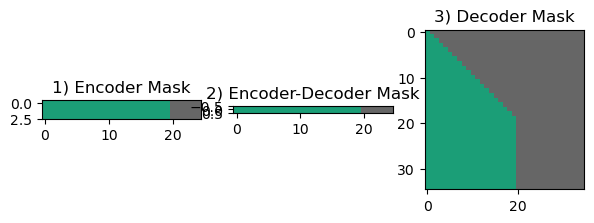

In [25]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = torch.zeros((batch, src_padding))
tgt_pad = torch.zeros((batch, tgt_padding))

sample_data = torch.ones((batch, length))
sample_src = torch.cat([sample_data, src_pad], dim=-1)
sample_tgt = torch.cat([sample_data, tgt_pad], dim=-1)

enc_mask, dec_enc_mask, dec_mask = generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [26]:
import math

class LearningRateScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, d_model, warmup_steps=4000, last_epoch=-1):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        super(LearningRateScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        step = max(1, self.last_epoch)
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        lr = (self.d_model ** -0.5) * min(arg1, arg2)
        return [lr for _ in self.base_lrs]

Learning Rate & Optimizer

In [27]:
# Learning Rate 인스턴스 선언


optimizer = torch.optim.Adam(transformer.parameters(),
                             betas=(0.9, 0.98),
                             eps=1e-9)

learning_rate = LearningRateScheduler(optimizer, d_model=512)

Loss Function 정의

3️⃣ Loss 함수를 정의하세요.
Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [28]:
loss_object = torch.nn.CrossEntropyLoss(reduction='none')

def loss_function(real, pred):
    mask = (real != 0)
    pred = pred.transpose(1, 2)
    loss_ = loss_object(pred, real)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = mask.float()
    loss_ *= mask

    return loss_.sum() / mask.sum()

In [29]:
# Train Step 정의
def train_step(src, tgt, model, optimizer):
    model.train()  # 모델을 training 모드로 전환
    optimizer.zero_grad()

    # 1) 입력/타깃을 먼저 device로 올리기
    src = src.to(device)      # 👈 추가
    tgt = tgt.to(device)      # 👈 추가

    # tgt의 오른쪽 시프트: decoder input과 gold target 분리
    tgt_in = tgt[:, :-1]  # Decoder의 입력
    gold = tgt[:, 1:]     # Decoder의 정답(target)


    # 마스크 생성 (generate_masks는 PyTorch용으로 변환된 함수여야 합니다)
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    src = src.to(device)
    tgt_in = tgt_in.to(device)
    enc_mask = enc_mask.to(device)
    dec_enc_mask = dec_enc_mask.to(device)
    dec_mask = dec_mask.to(device)

    # 모델 forward pass
    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)

    # loss 계산
    loss = loss_function(gold, predictions)

    # 역전파 수행 및 파라미터 업데이트
    loss.backward()
    optimizer.step()

    return loss, enc_attns, dec_attns, dec_enc_attns

print("슝=3")

슝=3


In [30]:
from tqdm import tqdm

In [31]:
%%time

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0.0
    dataset_count = len(train_dataloader)  # train_loader는 PyTorch DataLoader입니다.
    tqdm_bar = tqdm(total=dataset_count)

    for batch, (src, tgt) in enumerate(train_dataloader):
        # train_step 함수는 (loss, enc_attns, dec_attns, dec_enc_attns)를 반환합니다.
        loss, enc_attns, dec_attns, dec_enc_attns = train_step(src, tgt, transformer, optimizer)

        total_loss += loss.item()  # PyTorch에서는 loss.numpy() 대신 loss.item() 사용
        tqdm_bar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})
        tqdm_bar.update(1)

    tqdm_bar.close()
    print(f"Epoch {epoch+1}, Loss: {total_loss / dataset_count:.4f}")

100%|██████████| 148/148 [00:20<00:00,  7.23it/s, Batch Loss=11478.0459]


Epoch 1, Loss: 11456.9103


100%|██████████| 148/148 [00:20<00:00,  7.26it/s, Batch Loss=11438.7256]


Epoch 2, Loss: 11437.6704


100%|██████████| 148/148 [00:21<00:00,  7.02it/s, Batch Loss=11542.2627]


Epoch 3, Loss: 11427.0793


100%|██████████| 148/148 [00:21<00:00,  6.93it/s, Batch Loss=11371.1162]


Epoch 4, Loss: 11406.5716


100%|██████████| 148/148 [00:20<00:00,  7.10it/s, Batch Loss=11383.4346]


Epoch 5, Loss: 11391.0498


100%|██████████| 148/148 [00:20<00:00,  7.11it/s, Batch Loss=11316.0703]


Epoch 6, Loss: 11372.0242


100%|██████████| 148/148 [00:21<00:00,  7.05it/s, Batch Loss=11306.1221]


Epoch 7, Loss: 11355.5120


100%|██████████| 148/148 [00:21<00:00,  7.04it/s, Batch Loss=11281.9111]


Epoch 8, Loss: 11333.6423


100%|██████████| 148/148 [00:20<00:00,  7.06it/s, Batch Loss=11365.5557]


Epoch 9, Loss: 11311.3500


100%|██████████| 148/148 [00:20<00:00,  7.07it/s, Batch Loss=11236.9150]

Epoch 10, Loss: 11290.0514
CPU times: user 3min 28s, sys: 1.07 s, total: 3min 29s
Wall time: 3min 28s


# 번역 성능 측정하기

In [32]:
# 번역성능 측정
from nltk.translate.bleu_score import sentence_bleu

In [33]:
import torch
import torch.nn.functional as F

def translate(tokens, model, src_tokenizer, tgt_tokenizer):
    # tokens: 입력 토큰 리스트
    # MAX_LEN: 최대 길이 (전역 변수 혹은 상수)
    # device: 모델과 데이터가 위치한 디바이스

    # tokens 길이가 MAX_LEN보다 크면 자르고, 작으면 0으로 패딩
    if len(tokens) > MAX_LEN:
        tokens = tokens[:MAX_LEN]
    else:
        tokens = tokens + [0] * (MAX_LEN - len(tokens))

    # 배치 차원을 추가하여 텐서로 변환 (shape: [1, MAX_LEN])
    padded_tokens = torch.tensor([tokens], dtype=torch.long, device=device)

    ids = []
    # 디코더의 첫 입력은 BOS 토큰 (배치 차원 추가)
    output = torch.tensor([[tgt_tokenizer.bos_id]], dtype=torch.long, device=device)

    for i in range(MAX_LEN):
        # generate_masks는 padded_tokens와 현재 output으로부터 마스크들을 생성합니다.
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(padded_tokens, output)

        # 모델 예측: predictions shape: [batch, seq_len, num_classes]
        predictions, _, _, _ = model(padded_tokens, output, enc_padding_mask, combined_mask, dec_padding_mask)

        # 마지막 시퀀스 위치의 예측값을 소프트맥스 후 argmax로 선택
        predicted_id = predictions[0, -1].softmax(dim=-1).argmax(dim=-1).item()

        # EOS 토큰에 도달하면 현재까지의 예측 토큰 ids를 디코딩 후 반환
        if tgt_tokenizer.eos_id == predicted_id:
            result = tgt_tokenizer.decode(ids)
            return result

        ids.append(predicted_id)
        # 현재 output에 새로운 예측 토큰을 연결 (dim=1)
        new_token = torch.tensor([[predicted_id]], dtype=torch.long, device=device)
        output = torch.cat([output, new_token], dim=1)

    result = tgt_tokenizer.decode(ids)
    return result

print("슝=3")

슝=3


In [34]:
# 우선 한 문장만 평가하는 eval_bleu_single을 만들어 봅시다
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    src_tokens = src_tokenizer.encode(src_sentence)
    tgt_tokens = tgt_tokenizer.encode(tgt_sentence)

    if (len(src_tokens) > MAX_LEN): return None
    if (len(tgt_tokens) > MAX_LEN): return None

    reference = tgt_sentence.split()
    candidate = translate(src_tokens, model, src_tokenizer, tgt_tokenizer).split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)

    return score

print('슝=3')

슝=3


In [35]:
# 필요한 라이브러리 임포트
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [36]:
# 테스트 데이터 중에 하나를 골라 평가해 봅시다.
# Q. 인덱스를 바꿔가며 테스트해 보세요

test_idx = 0

eval_bleu_single(transformer,
                 test_questions[test_idx],
                 test_answers[test_idx],
                 tokenizer,
                 tokenizer)

Source Sentence:  죽을거 같네
Model Prediction:  []
Real:  ['나쁜', '생각', '하지', '마세요', '.']
Score: 0.000000



0

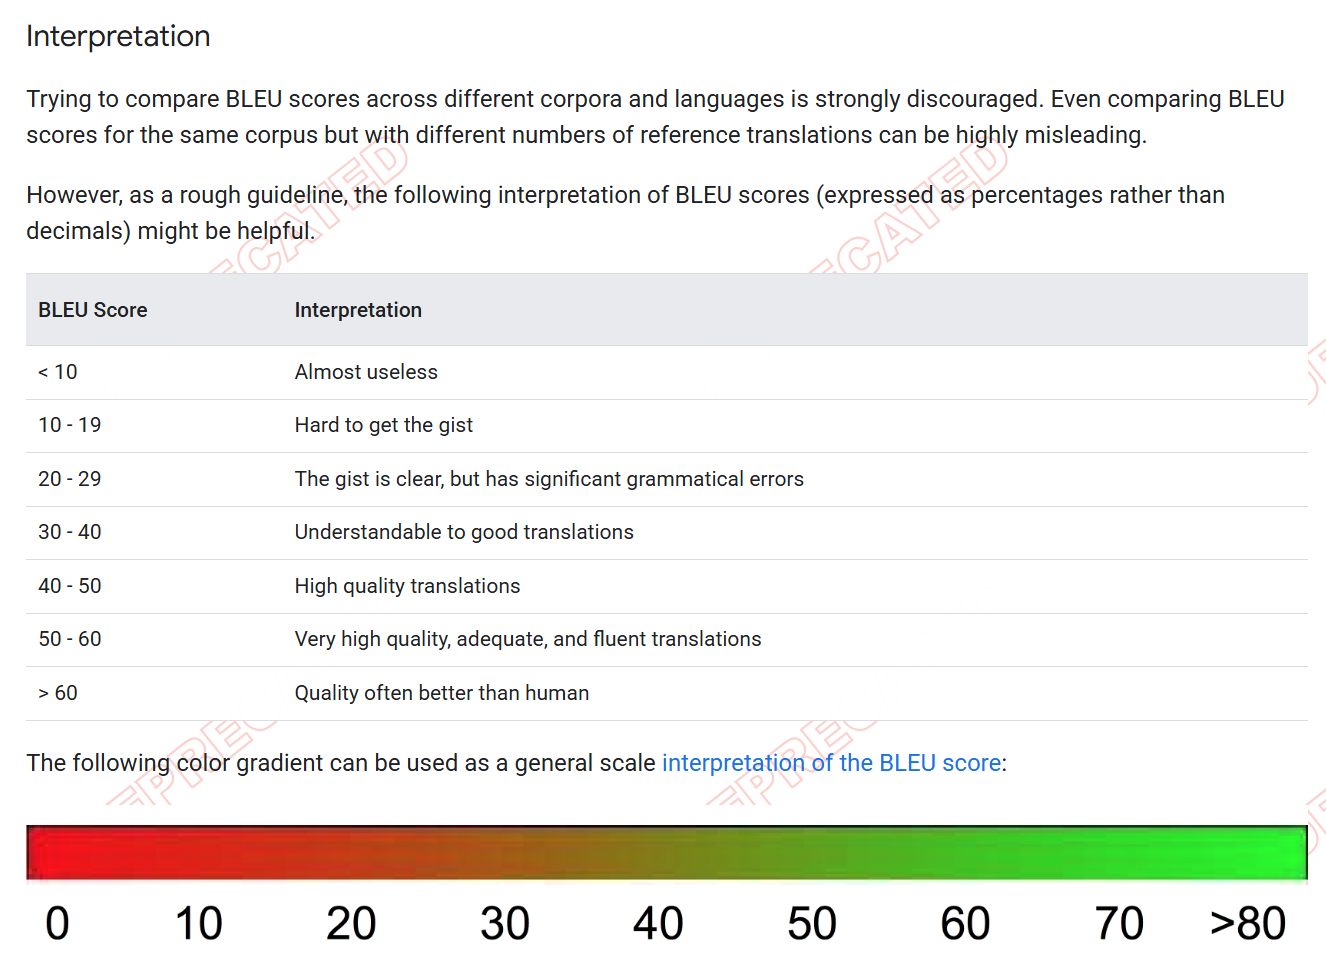
https://docs.cloud.google.com/translate/automl/docs/evaluate#bleu

In [147]:
def eval_bleu(model, src_sentences, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)

    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], src_tokenizer, tgt_tokenizer, verbose)
        if not score: continue

        total_score += score

    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)

print("슝=3")

슝=3


In [149]:
eval_bleu(transformer, test_questions, test_answers, tokenizer, tokenizer, verbose=False)

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

Num of Sample: 1
Total Score: 0.0


(2) Beam Search Decoder
이 멋진 평가 지표를 더 멋지게 사용하는 방법! 바로 모델의 생성 기법에 변화를 주는 것이죠. Greedy Decoding 대신 새로운 기법을 적용하면 우리 모델을 더 잘 평가할 수 있을 것 같네요! 

In [153]:
def beam_search_decoder(prob, beam_size):
    sequences = [[[], 1.0]]  # 생성된 문장과 점수를 저장

    for tok in prob:
        all_candidates = []

        for seq, score in sequences:
            for idx, p in enumerate(tok): # 각 단어의 확률을 총점에 누적 곱
                candidate = [seq + [idx], score * -math.log(-(p-1))]
                all_candidates.append(candidate)

        ordered = sorted(all_candidates,
                         key=lambda tup:tup[1],
                         reverse=True) # 총점 순 정렬
        sequences = ordered[:beam_size] # Beam Size에 해당하는 문장만 저장

    return sequences

print("슝=3")

슝=3


In [154]:
import torch
import torch.nn.functional as F

def calc_prob(src_ids, tgt_ids, model):
    # 마스크 생성 (PyTorch 버전)
    enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(src_ids, tgt_ids)

    # 모델 forward pass
    predictions, enc_attns, dec_attns, dec_enc_attns = model(
        src_ids,
        tgt_ids,
        enc_padding_mask,
        combined_mask,
        dec_padding_mask
    )

    # 마지막 차원에 대해 softmax 적용하여 확률값 계산
    return F.softmax(predictions, dim=-1)

print("슝=3")

슝=3


In [155]:
import numpy as np
import torch

def beam_search_decoder(sentence,
                        src_len,
                        tgt_len,
                        model,
                        src_tokenizer,
                        tgt_tokenizer,
                        beam_size):
    # 입력 문장을 토큰화
    tokens = src_tokenizer.encode_as_ids(sentence)

    # src_in: [1, src_len] 크기의 텐서로 padding (0: 패딩 토큰)
    padded = np.zeros((1, src_len), dtype=np.int64)
    padded[0, :len(tokens)] = tokens
    src_in = torch.tensor(padded, dtype=torch.long, device=device)

    # beam search용 캐시 배열들
    pred_cache = np.zeros((beam_size * beam_size, tgt_len), dtype=np.int64)
    pred_tmp = np.zeros((beam_size, tgt_len), dtype=np.int64)

    eos_flag = np.zeros((beam_size,), dtype=np.int64)  # EOS를 만난 branch 표시 (EOS: -1)
    scores = np.ones((beam_size,), dtype=np.float32)     # 각 branch의 score (확률 곱)

    # 디코더 첫 입력은 BOS 토큰
    pred_tmp[:, 0] = tgt_tokenizer.bos_id()

    # 초기 디코더 입력 (branch 0의 첫 토큰) -> shape: [1, 1]
    dec_in = torch.tensor(pred_tmp[0, :1], dtype=torch.long, device=device).unsqueeze(0)
    # calc_prob()는 softmax를 적용한 확률 텐서를 반환함
    prob = calc_prob(src_in, dec_in, model)[0, -1].detach().cpu().numpy()

    # seq_pos: 디코더 시퀀스 위치
    for seq_pos in range(1, tgt_len):
        score_cache = np.ones((beam_size * beam_size,), dtype=np.float32)

        # 각 beam branch에 대해 캐시 초기화
        for branch_idx in range(beam_size):
            cache_pos = branch_idx * beam_size
            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = pred_tmp[branch_idx, :seq_pos]

        # 각 beam branch에 대해 후보 확률 계산 및 캐시 업데이트
        for branch_idx in range(beam_size):
            cache_pos = branch_idx * beam_size
            if seq_pos != 1:
                # 해당 branch의 현재까지의 시퀀스를 디코더 입력으로 변환
                dec_in_np = pred_cache[branch_idx, :seq_pos]
                dec_in = torch.tensor(dec_in_np, dtype=torch.long, device=device).unsqueeze(0)
                prob = calc_prob(src_in, dec_in, model)[0, -1].detach().cpu().numpy()

            # 각 branch 내에서 beam_size만큼의 후보 토큰을 선택
            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)
                # 후보 branch의 score 업데이트 (곱셈으로 누적)
                score_cache[cache_pos + beam_idx] *= prob[max_idx]
                pred_cache[cache_pos + beam_idx, seq_pos] = max_idx
                # 이미 선택된 토큰은 다시 선택되지 않도록 -1로 마킹
                prob[max_idx] = -1

        # 각 beam branch에서 최고 score를 가진 후보를 선택
        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1:
                continue
            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1].copy()
            pred_tmp[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1  # 해당 후보 제거

            # 만약 EOS 토큰이면 해당 branch는 종료 표시 (-1)
            if prediction[-1] == tgt_tokenizer.eos_id():
                eos_flag[beam_idx] = -1

    # 각 branch의 예측 시퀀스에서 EOS 토큰 이전까지만 추출하여 결과 반환
    pred = []
    for long_pred in pred_tmp:
        eos_token = tgt_tokenizer.eos_id()
        # EOS 토큰이 없는 경우, 전체 시퀀스를 사용하도록 처리할 수 있음
        try:
            eos_idx = list(long_pred).index(eos_token)
        except ValueError:
            eos_idx = tgt_len - 1
        short_pred = long_pred[:eos_idx+1]
        pred.append(short_pred.tolist())

    return pred

print("슝=3")

슝=3


In [156]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                            candidate,
                            weights=weights,
                            smoothing_function=SmoothingFunction().method1)

print('슝=3')

슝=3


In [157]:
def beam_bleu(reference, ids, tokenizer):
    # 기준 문장을 토큰화
    reference_tokens = reference.split()

    total_score = 0.0
    num_candidates = len(ids)
    if num_candidates == 0:
        return 0.0

    for candidate_ids in ids:
        # 후보 문장을 디코딩 후 토큰화
        candidate_sentence = tokenizer.decode_ids(candidate_ids)
        candidate_tokens = candidate_sentence.split()

        score = calculate_bleu(reference_tokens, candidate_tokens)

        print(f"Reference: {reference_tokens}")
        print(f"Candidate: {candidate_tokens}")
        print(f"BLEU: {score}")

        total_score += score

    return total_score / num_candidates

print("슝=3")

슝=3


In [159]:
# Q. 인덱스를 바꿔가며 확인해 보세요
test_idx = 1

ids = \
beam_search_decoder(test_questions[test_idx],
                    MAX_LEN,
                    MAX_LEN,
                    transformer,
                    tokenizer,
                    tokenizer,
                    beam_size=5)

bleu = beam_bleu(test_answers[test_idx], ids, tokenizer)
print(bleu)

IndexError: list index out of range

# 번역 생성에는 아래 소스를 사용하시길 바랍니다!

In [ ]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data,
                        square=True,
                        vmin=0.0, vmax=1.0,
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [ ]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = torch.tensor(tokens).unsqueeze(0)

    ids = []
    output = torch.tensor([tgt_tokenizer.bos_id()]).unsqueeze(0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)

        predicted_id = torch.argmax(torch.softmax(predictions, dim=-1)[0, -1]).item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = torch.cat([output, torch.tensor([[predicted_id]])], dim=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)